# <center>A Data Oriented Approach to Recruitment</center>

<center>Wissem Belguidoum (wbelguidoum@gmail.com)</center>

<center>UCSanDiegoX : DSE200x</center>

<center>Final Project Submission</center>

## Table of content : 
   1. <a href='#1.-Abstract'>Abstract</a>
   2. <a href='#2.-Initialisation'>Initialisation</a> 
   3. <a href='#3.-Data-Exploration'>Data Exploration</a>
   4. <a href='#4.-Data-Analysis'>Data Analysis</a>
   5. <a href='#5.-Building-a-Model'>Building a Model</a>
   6. <a href='#6.-Applying-the-Model'>Applying the Model</a>
   7. <a href='#7.-Limitations-and-future-works'>Limitations and future-works</a>

## 1. Abstract

In this project we will try to leverage basic data analysis and machine learning techniques in order to help recruitment companies to find the top experts in each domains.

The dataset of choice is the stackoverflow public dataset (please find a link to the source and to a description below). 


The main question that will be discussed is the following : How can we identify the top expert profiles regarding a specific domain of expertise, by analysing users behaviour on the stackoverflow websites ?

In order to answer this question, we will train a regression model to predict a reputation score of a user by observing his behaviour in the stackoverflow web, and we will apply this model to predict the reputation of users in a specific domain of knowledge.

By the end of the notebook, we will identify a set of behavioural metrics that have the most impact in the reputation score.

<b>Dataset Source :</b>
    https://www.kaggle.com/stackoverflow/stackoverflow

<b>Dataset Schema :</b> 
    https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede
        

## 2. Initialisation

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import time

from math import sqrt

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### 2.1. How to use BigQuery in Jupyter 

Stackoverflow dataset is published in BigQuery in Google Cloud platform. 

BigQuery is a cloud solution developed by Google that helps working with big amount of data without the need to download it locally. 

BigQuery uses SQL to query the data. It also has a user interface that is accessible from the Google Cloud Console.

In this project we will access BigQuery from inside the Jupyter notebook. There is two different ways to do this :

* We can access using Python code. Here is a brief description of this method : https://jingsblog.com/2018/11/27/connect-your-jupyter-notebook-to-the-bigquery/

* We can also send queries using cell magic as described in the following article : https://cloud.google.com/bigquery/docs/visualize-jupyter

We will now follow the steps, and we will use both methods of access depending on the need : 


In [2]:
# Installing BigQuery Python packages : 

!pip install --upgrade google-cloud-bigquery[pandas]

Requirement already up-to-date: google-cloud-bigquery[pandas] in /home/wibe/anaconda3/lib/python3.7/site-packages (1.18.0)


In [4]:
# Defining an environement variable that points to my BigQuery API credentials file : 
%env GOOGLE_APPLICATION_CREDENTIALS=/home/wibe/Bureau/UCSDx1/ucsdx1-d232c1f77aff.json

# Enabling the bigquery magic cell
%load_ext google.cloud.bigquery

# Importing bigquery package
from google.cloud import bigquery

# Creating a bigquery client that will be used in the rest of this notebook : 
bigquery_client = bigquery.Client()


env: GOOGLE_APPLICATION_CREDENTIALS=/home/wibe/Bureau/UCSDx1/ucsdx1-d232c1f77aff.json
The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## 3. Data Exploration 

In the links that we put in the abstract, there is a detailed description of the schema of this dataset, but in this section we will focus on a subset of the data that captures users information and users behaviour, because we will try to create a solution that filters users based on their behaviour and impact. 

Let's first list all the tables available in the <b>bigquery-public-data.stackoverflow</b> database :


In [5]:
%%bigquery
SELECT *
FROM `bigquery-public-data.stackoverflow.INFORMATION_SCHEMA.TABLES`


,table_catalog,table_schema,table_name,table_type,is_insertable_into,is_typed,creation_time
0,bigquery-public-data,stackoverflow,posts_answers,BASE TABLE,YES,NO,2016-10-31 18:31:25.583000+00:00
1,bigquery-public-data,stackoverflow,users,BASE TABLE,YES,NO,2016-10-26 13:29:37.954000+00:00
2,bigquery-public-data,stackoverflow,posts_orphaned_tag_wiki,BASE TABLE,YES,NO,2016-10-31 16:41:37.010000+00:00
3,bigquery-public-data,stackoverflow,posts_tag_wiki,BASE TABLE,YES,NO,2016-10-31 16:22:35.603000+00:00
4,bigquery-public-data,stackoverflow,stackoverflow_posts,BASE TABLE,YES,NO,2016-09-21 13:42:24.544000+00:00
5,bigquery-public-data,stackoverflow,posts_questions,BASE TABLE,YES,NO,2016-11-01 15:33:29.219000+00:00
6,bigquery-public-data,stackoverflow,comments,BASE TABLE,YES,NO,2016-10-26 13:58:04.784000+00:00
7,bigquery-public-data,stackoverflow,posts_tag_wiki_excerpt,BASE TABLE,YES,NO,2016-10-31 15:16:33.226000+00:00
8,bigquery-public-data,stackoverflow,posts_wiki_placeholder,BASE TABLE,YES,NO,2016-10-31 16:17:55.646000+00:00
9,bigquery-public-data,stackoverflow,posts_privilege_wiki,BASE TABLE,YES,NO,2016-10-31 18:00:16.745000+00:00


We will focus on the subset of the tables that contain data about users and data about their interactions : users, stackoverflow_posts, posts_answers, comments


#### In a nutshell :

* The users of stackoverflow can :  
     * create posts : this information is stored in <b>stackoverflow_posts</b> table
     * respond to others' posts by posting an answer : this information is stored in <b>posts_answers</b> table
     * add a comment on others' posts : this information is stored in <b>comments</b> table
     * add a comment on others' answers : this information is also stored in <b>comments</b> table

* Users are associated with a reputation score stored in <b>users</b> table
* Comments can be linked to a user and either to a post, or to an answer



### 3.1. The <em>users</em> table 

In [6]:
%%bigquery
SELECT *
FROM `bigquery-public-data.stackoverflow.users`
LIMIT 5

,id,display_name,about_me,age,creation_date,last_access_date,location,reputation,up_votes,down_votes,views,profile_image_url,website_url
0,292,shsteimer,<p>I'm a senior consultant and technical archi...,None,2008-08-04 13:14:31.860000+00:00,2015-06-17 21:25:20.813000+00:00,"Pittsburgh, PA",16554,370,142,983,None,http://shsteimer.com
1,669,quekshuy,None,None,2008-08-07 16:11:17.027000+00:00,2019-06-01 00:24:01.957000+00:00,None,459,21,0,73,https://www.gravatar.com/avatar/06b9e1b05630e2...,None
2,695,Saltire,<p>Web developer since '98 for personal and co...,None,2008-08-07 23:02:44.527000+00:00,2019-05-31 14:50:53.973000+00:00,United Kingdom,483,127,2,32,None,None
3,1123,Magnar,<p>A happy front-end developer.</p>,None,2008-08-12 14:20:20.517000+00:00,2019-05-23 06:26:10.333000+00:00,Norway,24845,800,21,1057,None,http://framsieutvikling.no
4,1143,Quibblesome,<p>nothing.</p>,None,2008-08-12 18:58:24.510000+00:00,2019-05-31 17:25:22.403000+00:00,"Cambridge, United Kingdom",21312,1343,67,1836,https://i.stack.imgur.com/2Phfx.png?s=128&g=1,None


We will exclude some columns that will not be used in this project : 

In [7]:
%%bigquery
SELECT id, display_name, location, reputation
FROM `bigquery-public-data.stackoverflow.users`
LIMIT 5

,id,display_name,location,reputation
0,40,Kevin,"Philadelphia, PA",9387
1,116,Mark Harrison,"Piedmont, CA",177570
2,529,guitsaru,United States,578
3,905,Keith,"New Brighton, Wallasey, UK",96750
4,968,Biri,"Érd, Hungary",5999


Reputation is an overall score calculated by Stackoverflow, its value reflects the user overall impact on the community.

Let's learn more about the users table :

In [8]:
%%bigquery
SELECT count(*) users_count, min(reputation) min_reputation, 
max(reputation) max_reputation, avg(reputation) avg_reputation 
FROM `bigquery-public-data.stackoverflow.users`

,users_count,min_reputation,max_reputation,avg_reputation
0,10528666,1,1109230,107.546489


* The database contains +10 millions users.
* Reputation values are in the range [1, 1109230], and the average reputation is 107

### 3.2. The <em>stackoverflow_posts</em> table 

In [9]:
%%bigquery 
SELECT *
FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`
LIMIT 5

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,525063,Android Respond To URL in Intent,<p>I want my intent to be launched when the us...,525086,1,2,None,2009-02-08 02:55:56.867000+00:00,65,2016-04-10 03:28:09.653000+00:00,2015-08-15 10:24:12.720000+00:00,None,1529129.0,Isaac Waller,764272.0,None,1,132,android|url|android-intent|intentfilter|launch,91060
1,14128723,Eclipse -- Progress windows don't show up any ...,<p>I used to see both Building and Cleaning ac...,14128762,1,0,None,2013-01-02 20:31:53.523000+00:00,4,2013-01-02 20:34:55.003000+00:00,NaT,None,NaN,user1499731,NaN,None,1,13,java|eclipse,4272
2,20728,What's the best way to create ClickOnce deploy...,<p>Our team develops distributed winform apps....,20806,2,0,None,2008-08-21 18:35:04.410000+00:00,5,2015-11-30 02:03:49.403000+00:00,2015-11-30 02:03:49.403000+00:00,None,1321.0,whatknott,1321.0,None,1,13,winforms|deployment|clickonce,2534
3,6531409,iOS: how to get image dimensions without openi...,<p>In an iOS app I need to provide image filte...,8731972,2,2,None,2011-06-30 07:33:38.647000+00:00,4,2014-04-22 17:16:44.230000+00:00,2012-01-24 07:37:04.003000+00:00,user83950,NaN,user83950,NaN,None,1,7,ios4|uikit,2837
4,593205,action delegate with zero parameters,<p>I see this line in many online examples of ...,593223,2,3,None,2009-02-27 01:30:27.723000+00:00,6,2012-01-12 01:44:40.020000+00:00,2012-01-12 01:44:40.020000+00:00,None,8677.0,I. J. Kennedy,8677.0,None,1,21,c#|delegates|action,12377


In our analysis, we will not be interested in text fields like title and body, so we will remove them, along with some other fields that are irrelevant to our analysis. 

We are especially interested in fields that hold information about the user behaviour and impact (number of posts, number of comments, number of views ..etc)

We are also interested in columns that help identify the user, the post or the domain: id, user id and the list of tags.

In [10]:
%%bigquery 
SELECT id, owner_user_id, answer_count, comment_count, favorite_count, score, tags, view_count
FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`
LIMIT 5

,id,owner_user_id,answer_count,comment_count,favorite_count,score,tags,view_count
0,316861,26721.0,1,0,5,8,php|pdo|pdostatement,10538
1,318489,40322.0,2,0,5,3,.net|http|encoding|tcp|chunked-encoding,4491
2,277291,3827.0,2,0,7,8,java|eclipse|eclipse-plugin|eclipse-rcp,3050
3,629024,75505.0,2,0,6,2,asp.net|asp.net-mvc|deployment|automated-deploy,2580
4,1037604,NaN,2,0,7,5,iphone|scroll,5955


* owner_user_id : the id of the user who created the post, 
* answer_count : the number of answers trying to bring a solution to the problem described in the post
* comment_count : the number of comments made on the post (answers are different from comments)
* favorite_count : the number of people who clicked the star on top of the post
* score : the result of the vote on the post (thumbs up - thumbs down)
* tags : a list of tags separated by |
* view_count : the number of times the post was viewed

Now let’s apply some aggregations :

In [11]:
%%bigquery 
SELECT count(*) posts_count, max(view_count) max_view_count, 
       max(answer_count) max_answer_counts, max(comment_count) max_comments_count, 
       max(favorite_count) max_fav_count, max(score) max_score
FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`


,posts_count,max_view_count,max_answer_counts,max_comments_count,max_fav_count,max_score
0,31017889,3364629,518,133,7317,20546


### 3.3. The <em>posts_answers</em> table 

This table has the same structure as the posts table. 

Some of the fields are always empty (like view_count). That's because those fields are used exclusively for posts and not for answers. 

In [12]:
%%bigquery
SELECT *
FROM `bigquery-public-data.stackoverflow.posts_answers`
LIMIT 3

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,12085147,None,"<p>In theory, System.exit is signal JVM to sto...",None,None,0,None,2012-08-23 05:18:41.550000+00:00,None,2012-08-23 05:18:41.550000+00:00,NaT,None,NaN,None,1285615,12084432,2,0,None,None
1,12085148,None,<p>Could you try to separate audio and video? ...,None,None,0,None,2012-08-23 05:18:50.263000+00:00,None,2012-08-23 07:36:22.043000+00:00,2012-08-23 07:36:22.043000+00:00,None,1132951.0,None,723276,7224308,2,0,None,None
2,12085149,None,<p>You can use below query :</p>\n\n<pre><code...,None,None,0,None,2012-08-23 05:19:03.400000+00:00,None,2012-08-23 05:19:03.400000+00:00,NaT,None,NaN,None,1407421,12076646,2,0,None,None


As usual, we will exclude some fields and keep the most important (identification fields + impact fields) :

In [13]:
%%bigquery
SELECT id, owner_user_id, parent_id, comment_count, score
FROM `bigquery-public-data.stackoverflow.posts_answers`
LIMIT 3

,id,owner_user_id,parent_id,comment_count,score
0,55832858,7266317,6004032,0,0
1,55832872,5873109,55832746,3,0
2,55832876,5713047,16935965,0,0


* parent_id : is the id of the post that this answer is linked two.
* comment_count: users can also comment on answers, and this is the number of comments that this answer received 

Let’s do some aggregations over the answers table :


In [14]:
%%bigquery 
SELECT count(*) answers_count, max(comment_count) max_comments_count, max(score) max_score
FROM `bigquery-public-data.stackoverflow.posts_answers`

,answers_count,max_comments_count,max_score
0,27107580,157,30199


### 3.4. The <em>comments</em> table 
This table contains the comments that can be linked to a post or to an answer. Later, we will make difference between those two cases in our analysis, and count them as two different behaviours 

In [15]:
%%bigquery
SELECT *
FROM `bigquery-public-data.stackoverflow.comments`
LIMIT 10

,id,text,creation_date,post_id,user_id,user_display_name,score
0,40131403,"Not sure why you got a downvote for this, its ...",2014-09-05 04:27:49.067000+00:00,23377188,None,user764357,4
1,40148193,"@MatíasFidemraizer - he's shown his effort, wh...",2014-09-05 14:22:45.573000+00:00,25688029,None,user1017882,10
2,40157402,you can't use any `-` options inside a script ...,2014-09-05 19:30:54.393000+00:00,25692635,None,user3442743,6
3,40161850,You can have a form inside a `td` element but ...,2014-09-05 22:54:28.453000+00:00,25694862,None,user3559349,4
4,40163850,"@kevin Yup, this is ghetto polling that will m...",2014-09-06 01:46:41.170000+00:00,21369398,None,user246672,4
5,40166469,`exit(0)` terminates the program. In order to ...,2014-09-06 06:39:59.647000+00:00,25697469,None,user3920237,4
6,40173648,@FredOverflow `char` and `unsigned char` alway...,2014-09-06 15:21:56.693000+00:00,25701418,None,user743382,9
7,40175635,It is confusing and misleading to call this a ...,2014-09-06 17:17:52.023000+00:00,17421508,None,user663031,12
8,40224481,Try `format(*row)`,2014-09-08 16:32:59.953000+00:00,25728901,None,user3960432,4
9,40254384,This: `fatal error: numpy/arrayobject.h: No su...,2014-09-09 12:44:23.180000+00:00,25744933,None,user707650,4


We exclude unused columns : 

In [16]:
%%bigquery
SELECT id, post_id, user_id, score
FROM `bigquery-public-data.stackoverflow.comments`
LIMIT 3

,id,post_id,user_id,score
0,40131403,23377188,None,4
1,40148193,25688029,None,10
2,40157402,25692635,None,6


* Some row have user_id null, we will exclude those in our analysis later : 

Let's do some aggregations over the comments table : 

In [17]:
%%bigquery 
SELECT count(*) comments_count, max(score) max_score
FROM `bigquery-public-data.stackoverflow.comments`

,comments_count,max_score
0,73799233,1366


## 4. Data Analysis

The aim of this section is to use the tables above in order to analyse the data and try find a way to take advantage of the data to correctly guide our search for the experts in a given domain.  

* We will start by creating an aggregated view that represents the user information (id, reputation) combined with metrics that reflect the user interactions (number of posts, the total of the views over the user's posts, the total sum of the scores on the user's comments...etc)
* And then, we will run a set of correlation calculations

### 4.1 Agregated View 1 : User Posts 
Here we will group posts of the each users, and aggregate the different posts field to end up with a user view of the those fields :

In [18]:
%%bigquery user_posts_df

SELECT user_id, avg(user_reputation) as user_reputation, count(*) as posts_count, 
      sum(post_favorite_count) as posts_favorite_count, sum(post_score) as posts_score, 
      sum(post_view_count) as posts_view_count, sum(post_answers_count) as posts_answers_count, 
      sum(post_comments_count) as posts_comments_count 
FROM (
  SELECT users.id as user_id, users.reputation as user_reputation, posts.favorite_count as post_favorite_count, posts.score as post_score, posts.view_count as post_view_count, 
         posts.answer_count as post_answers_count,  posts.comment_count as post_comments_count
  FROM `bigquery-public-data.stackoverflow.stackoverflow_posts` as posts
  JOIN `bigquery-public-data.stackoverflow.users` as users on users.id = posts.owner_user_id
  WHERE mod(users.id, 1023) = 0 
) AS USER_POSTS
GROUP BY USER_POSTS.user_id

In [19]:
user_posts_df = user_posts_df.set_index('user_id')
user_posts_df.head(10)

,user_reputation,posts_count,posts_favorite_count,posts_score,posts_view_count,posts_answers_count,posts_comments_count
user_id,,,,,,,
1763652,1422.0,162,20.0,114,135308.0,299.0,373
117645,141.0,27,27.0,56,65067.0,54.0,22
104346,76.0,6,5.0,9,8754.0,10.0,2
182094,2210.0,58,22.0,208,22003.0,76.0,98
3216312,8287.0,255,3.0,570,1476.0,13.0,568
5987619,497.0,17,2.0,7,485.0,12.0,29
1617363,32.0,5,NaN,1,3058.0,6.0,2
3211197,841.0,41,6.0,49,9520.0,64.0,91
1005609,1470.0,79,14.0,104,90129.0,60.0,86


* In order to limit the number of targeted users, we used the modulo operator over the user's id.
* Some values are null, we will clean them later

### 4.2 Agregated View 2 : User Answers 
Here we will group answers of the each users, and compute aggregates in the same way we did for the posts : 

In [20]:
%%bigquery user_answers_df

SELECT user_id, count(*) as answers_count, sum(answers_score) as answers_score, 
       sum(answers_comments_count) as answers_comments_count 
FROM (
  SELECT users.id as user_id, answers.score as answers_score, 
        answers.comment_count as answers_comments_count
  FROM `bigquery-public-data.stackoverflow.posts_answers` as answers
  JOIN `bigquery-public-data.stackoverflow.users` as users on users.id = answers.owner_user_id 
  WHERE mod(users.id, 1023) = 0 
) AS USER_ANSWERS
GROUP BY USER_ANSWERS.user_id

In [21]:
user_answers_df = user_answers_df.set_index('user_id')
user_answers_df.head(10)

,answers_count,answers_score,answers_comments_count
user_id,,,
3480246,599,781,1193
1202025,2929,9135,8872
789756,144,200,212
5508855,16,17,18
1405602,27,15,28
2623995,12,10,17
292578,114,153,145
4800939,7,8,3
323268,20,59,31


* We used the same sampling method (modulo) and the same parameter (1023) as the last step, so we get the same users id that we got for the posts view 

### 4.3 Agregated View 3 : User Comments made on posts 


In [22]:
%%bigquery user_comments_on_posts_df

SELECT user_id, count(*) as comments_on_posts_count, sum(comment_score) as comments_on_posts_score
FROM (
  SELECT users.id as user_id, comments.score as comment_score
  FROM `bigquery-public-data.stackoverflow.comments` as comments
  JOIN `bigquery-public-data.stackoverflow.stackoverflow_posts` as posts on posts.id = comments.post_id
  JOIN `bigquery-public-data.stackoverflow.users` as users on users.id = comments.user_id 
  WHERE mod(users.id, 1023) = 0 
) AS USER_COMMENTS_ON_POSTS
GROUP BY USER_COMMENTS_ON_POSTS.user_id    


In [23]:
user_comments_on_posts_df = user_comments_on_posts_df.set_index('user_id')
user_comments_on_posts_df.head(10)

,comments_on_posts_count,comments_on_posts_score
user_id,,
285417,633,178
348843,74,2
378510,28,1
471603,4,0
1372866,41,134
5922147,11,0
117645,32,0
2052138,30,6
2167737,2,0


### 4.4 Agregated View 4 : User comments made on answers 


In [24]:
%%bigquery user_comments_on_answers_df

SELECT user_id, count(*) as comments_on_answers_count, sum(comment_score) as comments_on_answers_score
FROM (
  SELECT users.id as user_id, comments.score as comment_score
  FROM `bigquery-public-data.stackoverflow.comments` as comments
  JOIN `bigquery-public-data.stackoverflow.posts_answers` as answers on answers.id = comments.post_id
  JOIN `bigquery-public-data.stackoverflow.users` as users on users.id = comments.user_id 
  WHERE mod(users.id, 1023) = 0 
) AS USER_COMMENTS_ON_ANSWERS
GROUP BY USER_COMMENTS_ON_ANSWERS.user_id


In [25]:
user_comments_on_answers_df = user_comments_on_answers_df.set_index('user_id')
user_comments_on_answers_df.head(10)

,comments_on_answers_count,comments_on_answers_score
user_id,,
5997849,2,0
8321082,26,2
1305348,9,1
8599338,2,0
272118,76,34
3218358,71,1
5031114,71,15
1241922,1,0
1007655,23,0


### 4.5 Merging & Cleaning
Now we will merge the previous results and create a single view combining all the informations

In [26]:
# Merging on user_id
merged_view = user_posts_df.join(user_answers_df, how='left')
merged_view = merged_view.join(user_comments_on_posts_df, how='left')
merged_view = merged_view.join(user_comments_on_answers_df, how='left')

# Cleaning : filling null values with zeroes
merged_view = merged_view.fillna(0)
print(merged_view.shape)
merged_view.head(5)

(2739, 14)


,user_reputation,posts_count,posts_favorite_count,posts_score,posts_view_count,posts_answers_count,posts_comments_count,answers_count,answers_score,answers_comments_count,comments_on_posts_count,comments_on_posts_score,comments_on_answers_count,comments_on_answers_score
user_id,,,,,,,,,,,,,,
1763652,1422.0,162,20.0,114,135308.0,299.0,373,13.0,6.0,8.0,230.0,16.0,147.0,11.0
117645,141.0,27,27.0,56,65067.0,54.0,22,0.0,0.0,0.0,32.0,0.0,22.0,0.0
104346,76.0,6,5.0,9,8754.0,10.0,2,2.0,2.0,2.0,8.0,0.0,8.0,0.0
182094,2210.0,58,22.0,208,22003.0,76.0,98,46.0,138.0,66.0,83.0,63.0,54.0,20.0
3216312,8287.0,255,3.0,570,1476.0,13.0,568,257.0,616.0,565.0,614.0,235.0,285.0,54.0


The variables in this dataset can be splitted in two categories :
1.  Behavioral variables (all the variables except user_reputation) : metrics collected directly from user interactions 

2.  Computed variables (user_reputation) : that is computed by Stackoverflow in a way that we ignore, but we know that it indicates how the user is active and impactful (in overall)
   
In the next section we will analyze the correlation between user_reputation and the behavioral variables.

### 4.6 Correlations  Analysis 
Now that we created our merged view, let's run a correlation analysis and observe the relationships between the variables :

In [27]:
correlations = merged_view.corr()
correlations

,user_reputation,posts_count,posts_favorite_count,posts_score,posts_view_count,posts_answers_count,posts_comments_count,answers_count,answers_score,answers_comments_count,comments_on_posts_count,comments_on_posts_score,comments_on_answers_count,comments_on_answers_score
user_reputation,1.000000,0.959187,0.435409,0.994311,0.302688,0.226851,0.905606,0.955714,0.996223,0.902436,0.914827,0.981466,0.927126,0.951190
posts_count,0.959187,1.000000,0.429022,0.935099,0.327824,0.295045,0.975840,0.993345,0.936071,0.967352,0.974290,0.927167,0.980991,0.877473
posts_favorite_count,0.435409,0.429022,1.000000,0.460623,0.860963,0.680419,0.359636,0.371158,0.413204,0.316413,0.367165,0.416188,0.400773,0.455267
posts_score,0.994311,0.935099,0.460623,1.000000,0.325092,0.243603,0.867457,0.926473,0.997542,0.860905,0.877898,0.984779,0.893547,0.961941
posts_view_count,0.302688,0.327824,0.860963,0.325092,1.000000,0.779051,0.267112,0.258650,0.279915,0.215304,0.270904,0.289708,0.303949,0.325690
posts_answers_count,0.226851,0.295045,0.680419,0.243603,0.779051,1.000000,0.236061,0.200017,0.203774,0.152828,0.230200,0.215257,0.274044,0.249663
posts_comments_count,0.905606,0.975840,0.359636,0.867457,0.267112,0.236061,1.000000,0.975678,0.872297,0.994728,0.994752,0.862648,0.991319,0.793087
answers_count,0.955714,0.993345,0.371158,0.926473,0.258650,0.200017,0.975678,1.000000,0.932586,0.977950,0.974880,0.921193,0.978086,0.867403
answers_score,0.996223,0.936071,0.413204,0.997542,0.279915,0.203774,0.872297,0.932586,1.000000,0.869753,0.883416,0.986145,0.896931,0.959767
answers_comments_count,0.902436,0.967352,0.316413,0.860905,0.215304,0.152828,0.994728,0.977950,0.869753,1.000000,0.990705,0.857980,0.983835,0.785763


From the results above, we notice that user_reputation variable is highly correlated with some of the behavioral variable. 

Let's visualize the correlation of user_reputation with two of the variables.

The most correlated variable with user_reputation is answers_score : 

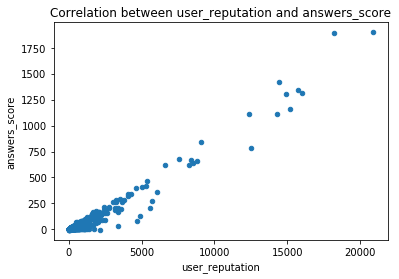

In [28]:
# We have to reduce the range of user_reputation in order to limit the dispersion : 
filtered_view = merged_view[merged_view['user_reputation'] < 40000]
filtered_view.plot(kind='scatter', x='user_reputation', y='answers_score', title='Correlation between user_reputation and answers_score')

The least correlated variable is posts_answers_count : 

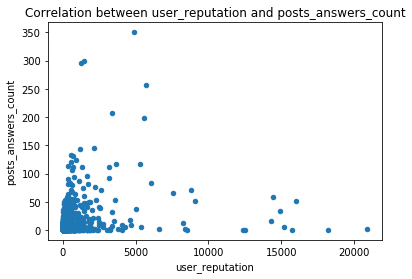

In [29]:
# We have to reduce the range of user_reputation in order to limit the dispersion : 
filtered_view = merged_view[merged_view['user_reputation'] < 40000]
filtered_view.plot(kind='scatter', x='user_reputation', y='posts_answers_count', title='Correlation between user_reputation and posts_answers_count')

### 4.7 Conclusion

Based on the observations above, we come to the conclusion that we can build a model to calculate user_reputation from a subset of the behavioural variables. 

In order to find this subset, we will fix a lower threshold of correlation to 95% and take all the variables above this threshold :

In [30]:
selected_features = correlations[['user_reputation']][(correlations[['user_reputation']] > 0.95) & (correlations[['user_reputation']] < 1)].dropna().index.values
selected_features

array(['posts_count', 'posts_score', 'answers_count', 'answers_score',
       'comments_on_posts_score', 'comments_on_answers_score'],
      dtype=object)

# 5. Building a Model

At this point, we came to the conclusion that in order to predict the impact (the reputation) of a user by observing his behaviour, we need to create a model that predicts the value of the user_reputation variable by giving as input the values of variables that we already selected based on their correlation user_reputation.

In this section, we will build and test the model, and we will apply it in the next and final section.

#### Model Type : 
Since user_reputation is an ordinal unlimited numerical value, we will opt for building a regression model.

We choose to build a <b>linear regressor</b>

But first, we need to write a python function, that will package the sampling steps that we saw earlier. Then, we can call this function to build a sample dataset : 

In [31]:
# This function will be used to create dataset to train and test the model : 

def build_sample_data(sampling_step) :

    # Step1 : Preparing queries 
    
    USER_POSTS_QUERY = """
SELECT user_id, avg(user_reputation) as user_reputation, count(*) as posts_count, sum(post_favorite_count) as posts_favorite_count, sum(post_score) as posts_score, sum(post_view_count) as posts_view_count, 
sum(post_answers_count) as posts_answers_count, sum(post_comments_count) as posts_comments_count 
FROM (
  SELECT users.id as user_id, users.reputation as user_reputation, posts.favorite_count as post_favorite_count, posts.score as post_score, posts.view_count as post_view_count, 
         posts.answer_count as post_answers_count,  posts.comment_count as post_comments_count
  FROM `bigquery-public-data.stackoverflow.stackoverflow_posts` as posts
  JOIN `bigquery-public-data.stackoverflow.users` as users on users.id = posts.owner_user_id
  WHERE mod(users.id, """ + str(sampling_step) + """) = 0 
) AS USER_POSTS
GROUP BY USER_POSTS.user_id
"""
    USER_ANSWERS_QUERY = """
SELECT user_id, count(*) as answers_count, sum(answers_score) as answers_score, sum(answers_comments_count) as answers_comments_count 
FROM (
  SELECT users.id as user_id, answers.score as answers_score, answers.comment_count as answers_comments_count
  FROM `bigquery-public-data.stackoverflow.posts_answers` as answers
  JOIN `bigquery-public-data.stackoverflow.users` as users on users.id = answers.owner_user_id 
  WHERE mod(users.id, """ + str(sampling_step) + """) = 0 
) AS USER_ANSWERS
GROUP BY USER_ANSWERS.user_id
    """
    
    USER_COMMENTS_ON_POSTS_QUERY = """
SELECT user_id, count(*) as comments_on_posts_count, sum(comment_score) as comments_on_posts_score
FROM (
  SELECT users.id as user_id, comments.score as comment_score
  FROM `bigquery-public-data.stackoverflow.comments` as comments
  JOIN `bigquery-public-data.stackoverflow.stackoverflow_posts` as posts on posts.id = comments.post_id
  JOIN `bigquery-public-data.stackoverflow.users` as users on users.id = comments.user_id 
  WHERE mod(users.id, """ + str(sampling_step) + """) = 0 
) AS USER_COMMENTS_ON_POSTS
GROUP BY USER_COMMENTS_ON_POSTS.user_id    
    """
    
    USER_COMMENTS_ON_ANSWERS_QUERY = """ 
SELECT user_id, count(*) as comments_on_answers_count, sum(comment_score) as comments_on_answers_score
FROM (
  SELECT users.id as user_id, comments.score as comment_score
  FROM `bigquery-public-data.stackoverflow.comments` as comments
  JOIN `bigquery-public-data.stackoverflow.posts_answers` as answers on answers.id = comments.post_id
  JOIN `bigquery-public-data.stackoverflow.users` as users on users.id = comments.user_id 
  WHERE mod(users.id, """ + str(sampling_step) + """) = 0 
) AS USER_COMMENTS_ON_ANSWERS
GROUP BY USER_COMMENTS_ON_ANSWERS.user_id    
    """

    # Step2 : Querying data from bigquery
    user_posts_df = bigquery_client.query(USER_POSTS_QUERY).to_dataframe().set_index('user_id')
    user_answers_df = bigquery_client.query(USER_ANSWERS_QUERY).to_dataframe().set_index('user_id')
    user_comments_on_posts_df =  bigquery_client.query(USER_COMMENTS_ON_POSTS_QUERY).to_dataframe().set_index('user_id')
    user_comments_on_answers_df =  bigquery_client.query(USER_COMMENTS_ON_ANSWERS_QUERY).to_dataframe().set_index('user_id')
    
    # Step3 : Combining the results in a single dataframe
    result = user_posts_df.join(user_answers_df, how='left')
    result = result.join(user_comments_on_posts_df, how='left')
    result = result.join(user_comments_on_answers_df, how='left')
    
    # Step4 : Cleaning and returning the final result  
    return result.fillna(0)


In [51]:
# Sampling the data with a step of 523 : 

sample_data = build_sample_data(sampling_step = 523)
print(sample_data.shape)
sample_data.head(5)

(5371, 14)


,user_reputation,posts_count,posts_favorite_count,posts_score,posts_view_count,posts_answers_count,posts_comments_count,answers_count,answers_score,answers_comments_count,comments_on_posts_count,comments_on_posts_score,comments_on_answers_count,comments_on_answers_score
user_id,,,,,,,,,,,,,,
2446071,1903.0,117,19.0,166,139401.0,240.0,413,11.0,25.0,17.0,432.0,64.0,320.0,56.0
618186,5187.0,98,26.0,412,168558.0,100.0,175,45.0,318.0,90.0,227.0,95.0,169.0,94.0
169452,75.0,5,1.0,5,1211.0,3.0,0,4.0,1.0,0.0,2.0,0.0,6.0,0.0
2960180,1.0,5,0.0,-5,193.0,4.0,10,2.0,0.0,2.0,9.0,0.0,6.0,0.0
40794,81.0,5,4.0,9,1815.0,1.0,10,2.0,3.0,3.0,4.0,1.0,0.0,0.0


Let's take a look at the sample data :

In [52]:
sample_data.describe()

,user_reputation,posts_count,posts_favorite_count,posts_score,posts_view_count,posts_answers_count,posts_comments_count,answers_count,answers_score,answers_comments_count,comments_on_posts_count,comments_on_posts_score,comments_on_answers_count,comments_on_answers_score
count,5371.000000,5371.000000,5371.000000,5371.000000,5.371000e+03,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000
mean,442.178551,11.816980,2.099981,27.261962,6.283558e+03,6.881028,18.494508,9.327127,32.115249,13.278719,18.328058,6.348538,12.689629,3.902067
std,4730.824538,67.066058,15.946707,337.191835,3.458810e+04,25.831458,123.881355,71.173934,442.000079,131.111880,122.527490,76.768594,73.447066,33.764273
min,1.000000,1.000000,0.000000,-13.000000,0.000000e+00,0.000000,0.000000,0.000000,-14.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16.000000,2.000000,0.000000,1.000000,2.360000e+02,1.000000,3.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000
75%,83.000000,5.000000,1.000000,5.000000,1.600500e+03,4.000000,9.000000,2.000000,3.000000,2.000000,7.000000,0.000000,6.000000,0.000000
max,270807.000000,3397.000000,795.000000,20770.000000,1.162686e+06,634.000000,6870.000000,3706.000000,26294.000000,7442.000000,4970.000000,3269.000000,3179.000000,1526.000000


### 5.1 Training a linear regressor : 

We will use the sample dataset, and the list of features that we selected earlier, to build a linear regression model that will be used to predict the value of user_reputation from the values of the selected behavioural features :

In [65]:
target = ['user_reputation']

X = sample_data[selected_features]

y = sample_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### 5.2 Testing the linear regressor : 


In [66]:
# Testing the regressor
y_prediction = regressor.predict(X_test)

In [114]:
# We merge the predicted reputation and the observed reputation 
# in the same dataframe in order to facilitate the comparaison : 

comparaison = y_test.copy()
comparaison['predicted_reputation'] = y_prediction
comparaison.head()

,user_reputation,predicted_reputation
user_id,,
2055913,1.0,20.096500
990039,1.0,26.409444
3658385,51.0,48.266967
2806941,1.0,34.120071
2447640,11.0,29.289841


In [115]:
# We sort the comparaison dataframe in a descending order of predicted_reputation
comparaison = comparaison.sort_values(['predicted_reputation'], ascending=False)
comparaison.head(20)

,user_reputation,predicted_reputation
user_id,,
501557,270807.0,312701.176775
608772,53624.0,55889.444687
343088,42090.0,44200.055061
256793,41652.0,42507.485190
472792,34732.0,39579.336788
4955425,27499.0,23363.253819
1265660,19083.0,22197.602649
1569,20183.0,20218.634707
3661,17117.0,18689.254332


* Although the values differs, but we can see that the order of ranking is almost preserved.

Let's now calculate the Root Mean Squared Error of the model : 

In [110]:
# Calculating RMSE : 
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(RMSE)

1061.4369735701096


The overall RMSE value is useful to compare between two different models. But per se, it gives few insight on the quality of the model.

We found out that by visualising the sorted comparaison dataframe, with a log scale over y axis, and by using the ranking as x axis, this gives a lot more insight on the quality of the model. 

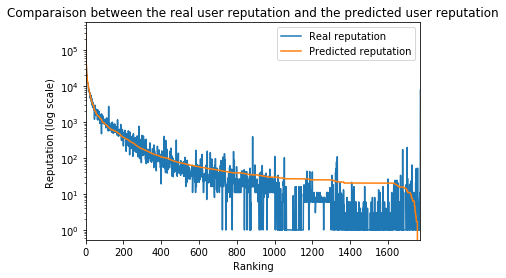

In [117]:
# Replace the index of the dataframe with row num :
comparaison.index = range(comparaison.shape[0])
comparaison.columns = ['Real reputation', 'Predicted reputation']

# Plotting the result : 
ax1 = comparaison.plot(logy=True, title='Comparaison between the real user reputation and the predicted user reputation')
ax1.set_xlabel('Ranking')
ax1.set_ylabel('Reputation (log scale) ')
ax1.tick_params(axis='y')

With the graph above, we can make the following observations about the quality of the regressor : 
1. The error is relatively small for the top ranking users, and it increases as the ranking increases, to reach a chaotic level of error by the end of the ranking axis.
2. The predicted reputation shows values that are less than 1, which is by definition not possible for a reputation in stackoverflow.
3. To the most right side we can spot some of the users that have a very high reputation in reality, yet their predicted reputation was one of the lowest.

### 5.3 Conclusion 
This regressor is not good in overall, but since we are interested in finding only the top ranking profiles, this will moderate the risks of error.

In the next section, we will see how to apply this model to find the best experts in their domain of expertise.


## 6. Applying the Model


In this final section we use the model created in the last section, in order to look for the best of the best talents in their domain.

First we need to write a function similar to the sampling function, but that will build a dataset based on tags: 

In [43]:
def search_users_data(tag) :

    # Step1 : Preparing queries 
    
    USER_POSTS_BY_TAG_QUERY = """
SELECT user_id, count(*) as posts_count, sum(post_favorite_count) as posts_favorite_count, sum(post_score) as posts_score, sum(post_view_count) as posts_view_count, 
sum(post_answers_count) as posts_answers_count, sum(post_comments_count) as posts_comments_count 
FROM (
  SELECT users.id as user_id, posts.favorite_count as post_favorite_count, posts.score as post_score, posts.view_count as post_view_count, 
         posts.answer_count as post_answers_count,  posts.comment_count as post_comments_count
  FROM `bigquery-public-data.stackoverflow.stackoverflow_posts` as posts
  JOIN `bigquery-public-data.stackoverflow.users` as users on users.id = posts.owner_user_id
  WHERE posts.tags like "%""" + tag + """%"
) AS USER_POSTS
GROUP BY USER_POSTS.user_id
"""
    USER_ANSWERS_BY_TAG_QUERY = """
SELECT user_id, count(*) as answers_count, sum(answers_score) as answers_score, sum(answers_comments_count) as answers_comments_count 
FROM (
  SELECT users.id as user_id, answers.score as answers_score, answers.comment_count as answers_comments_count
  FROM `bigquery-public-data.stackoverflow.posts_answers` as answers
  JOIN `bigquery-public-data.stackoverflow.stackoverflow_posts` as posts on posts.id = answers.parent_id
  JOIN `bigquery-public-data.stackoverflow.users` as users on users.id = answers.owner_user_id 
  WHERE posts.tags like "%""" + tag + """%"
) AS USER_ANSWERS
GROUP BY USER_ANSWERS.user_id
    """
    
    USER_COMMENTS_ON_POSTS_BY_TAG_QUERY = """
SELECT user_id, count(*) as comments_on_posts_count, sum(comment_score) as comments_on_posts_score
FROM (
  SELECT users.id as user_id, comments.score as comment_score
  FROM `bigquery-public-data.stackoverflow.comments` as comments
  JOIN `bigquery-public-data.stackoverflow.stackoverflow_posts` as posts on posts.id = comments.post_id
  JOIN `bigquery-public-data.stackoverflow.users` as users on users.id = comments.user_id 
  WHERE posts.tags like "%""" + tag + """%"
) AS USER_COMMENTS_ON_POSTS
GROUP BY USER_COMMENTS_ON_POSTS.user_id    
    """
    
    USER_COMMENTS_ON_ANSWERS_BY_TAG_QUERY = """ 
SELECT user_id, count(*) as comments_on_answers_count, sum(comment_score) as comments_on_answers_score
FROM (
  SELECT users.id as user_id, comments.score as comment_score
  FROM `bigquery-public-data.stackoverflow.comments` as comments
  JOIN `bigquery-public-data.stackoverflow.posts_answers` as answers on answers.id = comments.post_id
  JOIN `bigquery-public-data.stackoverflow.stackoverflow_posts` as posts on posts.id = answers.parent_id
  JOIN `bigquery-public-data.stackoverflow.users` as users on users.id = comments.user_id 
  WHERE posts.tags like "%""" + tag + """%"
) AS USER_COMMENTS_ON_ANSWERS
GROUP BY USER_COMMENTS_ON_ANSWERS.user_id    
    """

    # Step2 : Querying data from bigquery

    user_posts_df = bigquery_client.query(USER_POSTS_BY_TAG_QUERY).to_dataframe().set_index('user_id')
    user_answers_df = bigquery_client.query(USER_ANSWERS_BY_TAG_QUERY).to_dataframe().set_index('user_id')
    user_comments_on_posts_df =  bigquery_client.query(USER_COMMENTS_ON_POSTS_BY_TAG_QUERY).to_dataframe().set_index('user_id')
    user_comments_on_answers_df =  bigquery_client.query(USER_COMMENTS_ON_ANSWERS_BY_TAG_QUERY).to_dataframe().set_index('user_id')
    
    # Step3 : Combining the results in a single dataframe
    result = user_posts_df.join(user_answers_df, how='left')
    result = result.join(user_comments_on_posts_df, how='left')
    result = result.join(user_comments_on_answers_df, how='left')
    
    return result.fillna(0)



### 6.1 Creating an Input dataset 

Now, we are ready to apply the model. 

Let's for example look for the best experts in the domain of <b>Pandas</b> (Data Science library for Python).

To do so, we first create a dataset based on the tag (pandas).

In [45]:
experts = search_users_data(tag='pandas')
print(experts[selected_features].shape)
experts[selected_features].head()

(9337, 6)


,posts_count,posts_score,answers_count,answers_score,comments_on_posts_score,comments_on_answers_score
user_id,,,,,,
327702,1,0,0.0,0.0,0.0,0.0
1377107,1,18,4.0,8.0,0.0,0.0
5539711,1,0,0.0,0.0,1.0,0.0
649920,1,0,0.0,0.0,0.0,0.0
1639671,1,1,1.0,0.0,0.0,1.0


* We have found 9337 users who have made at least one action (posting, answering, commenting), on a post that is tagged as a 'pandas' post.

### 6.2 Applying the regressor to the input dataset

Now, using the created dataset of pandas experts, let's use the our regressor in order to associate a "Pandas expert reputation" with each user in the dataset : 


In [46]:
prediction = regressor.predict(experts[selected_features])

In [47]:
experts['predicted_reputation'] = prediction


### 6.3 Getting the list of the TOP 10 best talents :


In [97]:
# Sorting by predicted reputation, and taking the first 10 users 
top10_experts = experts.sort_values(['predicted_reputation'], ascending=False)[0:10]
top10_experts['ranking'] = [x + 1 for x in range(10)]
top10_experts[['predicted_reputation', 'ranking', *selected_features]]

,predicted_reputation,ranking,posts_count,posts_score,answers_count,answers_score,comments_on_posts_score,comments_on_answers_score
user_id,,,,,,,,
1240268,138053.045102,1,2,108,1217.0,15715.0,339.0,692.0
190597,111958.834043,2,3,15,1070.0,12566.0,113.0,342.0
704848,111862.707916,3,1,6,1958.0,12711.0,1673.0,518.0
653364,45778.744011,4,5,32,449.0,5281.0,369.0,220.0
1426056,29203.725904,5,6,32,123.0,3338.0,6.0,37.0
1427416,27387.271434,6,5,37,242.0,3172.0,204.0,156.0
2411802,25252.777460,7,9,20,921.0,2434.0,92.0,64.0
484596,19838.798051,8,3,11,18.0,2301.0,0.0,4.0
625914,18920.032137,9,3,29,216.0,2121.0,104.0,26.0


Let's take a look at the experts we found.

But first, we need to write a utility function that allows as to seek users from bigquery database by id :


In [98]:
def get_user_by_id(user_id) :
    QUERY = """
    SELECT *
    FROM `bigquery-public-data.stackoverflow.users`
    WHERE id = """ + str(user_id) + """
    """
    return bigquery_client.query(QUERY).to_dataframe()
    

Now, we can display each expert and a link to his stackoverflow profile (those are real users, you can check their Stack Overflow profiles by following the links) : 

In [99]:
for index, topexpert in top10_experts.iterrows():
    user = get_user_by_id(index)
    name = user['display_name'][0]
    ranking = topexpert['ranking']
    print("Expert #", ranking,": ", name, "(https://stackoverflow.com/users/{0}/{1})".format(index, name))

Expert # 1.0 :  Andy Hayden (https://stackoverflow.com/users/1240268/Andy Hayden)
Expert # 2.0 :  unutbu (https://stackoverflow.com/users/190597/unutbu)
Expert # 3.0 :  EdChum (https://stackoverflow.com/users/704848/EdChum)
Expert # 4.0 :  joris (https://stackoverflow.com/users/653364/joris)
Expert # 5.0 :  waitingkuo (https://stackoverflow.com/users/1426056/waitingkuo)
Expert # 6.0 :  BrenBarn (https://stackoverflow.com/users/1427416/BrenBarn)
Expert # 7.0 :  Alexander (https://stackoverflow.com/users/2411802/Alexander)
Expert # 8.0 :  Aman (https://stackoverflow.com/users/484596/Aman)
Expert # 9.0 :  behzad.nouri (https://stackoverflow.com/users/625914/behzad.nouri)
Expert # 10.0 :  ely (https://stackoverflow.com/users/567620/ely)


At this point, our work is done, and the recruitment company extracted successfully a list of top 10 experts in the domain of Pandas. The next action is to get in touch with the candidates in order to make a job offer.

## 7. Limitations and future works 

Despite the medium quality of the model, the result is still satisfying in the sense that we succeeded in extracting a list of real top experts in their domain.

There is more than one way to improve upon this work: 
- Use other sources to gain deeper knowledge of the users : use text of posts and comments, track user activity in time.
- Improved search : multi-tags search, synonym of tags search, search by geographical location, search by date range
- This work was limited to the scope of stackoverflow data, in the future we can as well, extend this work to use other data sources like LinkedIn, Medium, Open Source repositories... etc
